# Simple permeation simulation

In this task, we'll go through the basics of FESTIM and run a simple permeation simulation on a 1D domain.

In [1]:
import festim as F

The first step is to create a model using a `Simulation` object.

In [2]:
my_model = F.Simulation()

We'll consider a 3 mm-thick material and a regular mesh (1000 cells)

In [3]:
import numpy as np

my_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, 3e-4, num=1001)
)

`Material` objects hold the materials properties like diffusivity and solubility.

Here we only need the diffusivity defined as an Arrhenius law: $D = D_0 \exp{(-E_D/k_B T)}$ where $k_B$ is the Boltzmann constant in eV/K and $T$ is the temperature in K. From this, the pre-exponential coefficient, $D_0$ in units m<sup>2</sup>/s, and the diffusion actiavtion energy, $E_D$ in units eV are needed.`

In [4]:
my_model.materials = F.Material(id=1, D_0=1.9e-7, E_D=0.2)

The temperature is set at 500 K

In [5]:
my_model.T = F.Temperature(value=500)

FESTIM has a `SievertsBC` class representing Sievert's law of solubility: $c = S \ \sqrt{P}$ at metal surfaces.

> Note:
> 
> A similar class exists for non-metallic materials behaving according to Henry's law: `HenrysBC`

We'll use this boundary condition on the left surface (`id=1`) and will assume a zero concentration on the right side (`id=2`).

In [6]:
P_up = 100  # Pa

my_model.boundary_conditions = [
    F.SievertsBC(surfaces=1, S_0=4.02e21, E_S=1.04, pressure=P_up),
    F.DirichletBC(surfaces=2, value=0, field=0)
]

With `Settings` we set the main solver parameters.

In [7]:
my_model.settings = F.Settings(
    absolute_tolerance=1e-2,
    relative_tolerance=1e-10,
    final_time=100  # s
    )

Let's choose a stepsize small enough to have good temporal resolution, with 1% change ratio:

In [8]:
my_model.dt = F.Stepsize(initial_value=1/20)

For this permeation experiment, we are only interested in the hydrogen flux on the right side:

In [9]:
derived_quantities = F.DerivedQuantities([F.HydrogenFlux(surface=2)])

my_model.exports = [derived_quantities]

In [10]:
my_model.initialise()

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Ellapsed time so far: 13.1 s


This problem can be solved analytically. The solution for the downstream flux is:

$$\mathrm{downstream \ flux} = \frac{P_\mathrm{up} \Phi}{L} \left(1 + 2 \sum_{n=1}^{\infty} \left(-1\right)^{n} \exp{(- \frac{\pi^{2} D n^{2} t}{L^{2}})}\right) $$

In [11]:
def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): material permeability
        L (float): material thickness
        D (float): diffusivity of H in the material

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up**0.5 * permeability / L * (2*summation + 1)

We can compare the computed downstream flux to the analytical solution:

Text(0, 0.5, 'Downstream flux (H/m2/s)')

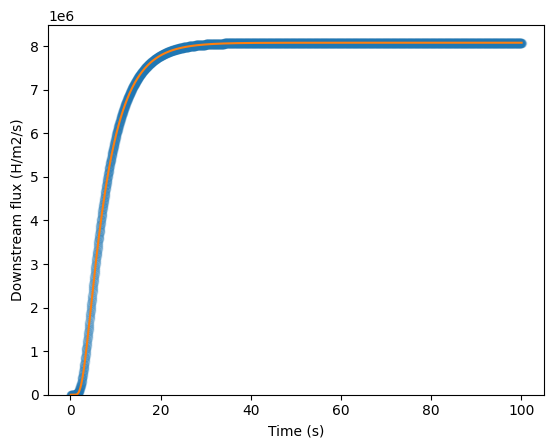

In [12]:
times = derived_quantities.t
computed_flux = derived_quantities.filter(surfaces=2).data

D = 1.9e-7*np.exp(-0.2/F.k_B/500)
S = 4.02e21*np.exp(-1.04/F.k_B/500)

import matplotlib.pyplot as plt
plt.scatter(times, np.abs(computed_flux), alpha=0.2, label="computed")
plt.plot(times, downstream_flux(times, P_up, permeability=D*S, L=3e-4, D=D), color="tab:orange", label="analytical")
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")

Phew! We have a good agreement between our model and the analytical solution!

To reproduce simple permeation experiments, the analytical solution is obviously enough.
However, for more complex scenarios (transients, trapping regimes,..) a numerical model provides more flexibility.


## Task

1) Add a trap with the following properties to the model:

    $k_0 = 3.8\times 10^{-17}$ m3/s

    $E_k = 0.2$ eV

    $p_0 = 10^{13}$ 1/s

    $E_p =1.2$ eV

    density: $10^{19}$ trap/m3

    <details>
    <summary>Show solution</summary>
    <br>
    To add a trap to the simulation, simply add the following lines

    ```python
    trap = F.Trap(
            k_0=3.8e-17,
            E_k=0.2,
            p_0=1e13,
            E_p=1.2,
            density=1e19,
            materials=my_model.materials.materials[0]
        )

    my_model.traps = [trap]
    ```

    </br>
    </details><br />


2) What can you observe on the permeation curve?

    <details>
    <summary>Show solution</summary>
    <br>

    The presence of a trap delays the permeation curve.
    
    However, the steady state permeation flux is unchanged.

    ![image](https://github.com/RemDelaporteMathurin/FESTIM-workshop/assets/40028739/74b7f8aa-67f6-4a70-b712-fc994b272622)

    </br>
    </details>